# Micro-proyecto # 1

__Detección de paletas de color a partir de obras de arte.__

Autores: Andrés Vega, David Méndez Acuña

## Intro

En este notebook se explora una manera de obtener paletas de colores a partir de imágenes. Se practicaron los conceptos de aplanamiento y normalización de las imágenes para reducir dimensionalidad y permitir la ejecución del modelo con buen rendimiento. Se aplicó el algoritmo de K-Means, dando como parámetro del modelo los 6 clusters que son requeridos por el ejercicio (entre 5 y 7), se hizo la agrupación y posterior graficación de los resultados.

## Importación de librerías requeridas

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

## Recopilación de un conjunto diverso de imágenes

Se define el directorio raíz `root_path` y la lista de imágenes `img_files`:

In [2]:
root_path = 'images'
img_files = os.listdir(root_path)
img_files

['alfred-stevens_portrait-of-mrs-howe-1900.jpg',
 'adam-baltatu_meridional-landscape.jpg',
 'albert-gleizes_acrobats-1916.jpg',
 'aldo-mondino_caduta-di-stella-1968.jpg',
 'edward-hopper_cape-cod-afternoon.jpg',
 'albert-gleizes_femme-cubiste-1921.jpg',
 'aki-kuroda_untitled-1995.jpg',
 'aaron-siskind_acolman-1-1955.jpg',
 'aki-kuroda_cosmogarden-2011.jpg']

## Carga de datos

Se define una funcion `load_images()` para la carga de las imágenes. Esta función asume que se tiene un directorio o carpeta con las imágenes, y utiliza funciones como `imread()` y `cvtColor()` para realizar la carga y procesamiento de cada una:

In [3]:
def load_images(root_path, file_names, flatten=True, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

## Preparación de los datos

Se realiza la carga de las imágenes sin modificaciones, es decir, manteniendo tanto las dimensiones originales como los valores de píxeles:

In [4]:
img_original = load_images(root_path, img_files, flatten=False, normalize=False)
img_original

[array([[[ 17,  16,  14],
         [ 17,  16,  14],
         [ 18,  17,  15],
         ...,
         [149,  55,  47],
         [159,  65,  57],
         [156,  62,  54]],
 
        [[ 17,  16,  14],
         [ 18,  17,  15],
         [ 18,  17,  15],
         ...,
         [146,  52,  44],
         [160,  66,  58],
         [161,  67,  59]],
 
        [[ 17,  16,  14],
         [ 17,  16,  14],
         [ 18,  17,  15],
         ...,
         [144,  50,  40],
         [161,  67,  57],
         [167,  73,  63]],
 
        ...,
 
        [[148,  64,  54],
         [147,  65,  53],
         [149,  67,  56],
         ...,
         [ 72,  45,  54],
         [ 69,  42,  51],
         [ 71,  44,  53]],
 
        [[225, 150, 145],
         [226, 151, 146],
         [227, 154, 148],
         ...,
         [177, 157, 166],
         [178, 158, 169],
         [177, 157, 166]],
 
        [[255, 191, 192],
         [255, 192, 193],
         [255, 194, 195],
         ...,
         [224, 213, 221],
  

Por otro lado, se hace la carga de las imágenes como una lista de píxeles, normalizando sus valores para que estén en el rango [0, 1]. Este será el conjunto de datos que se utilizará para el entrenamiento del modelo:

In [5]:
img_list = load_images(root_path, img_files, flatten=True, normalize=True)
img_list

[array([[0.06666667, 0.0627451 , 0.05490196],
        [0.06666667, 0.0627451 , 0.05490196],
        [0.07058824, 0.06666667, 0.05882353],
        ...,
        [0.87843137, 0.83529412, 0.86666667],
        [0.89803922, 0.85098039, 0.89019608],
        [0.87058824, 0.82745098, 0.85882353]]),
 array([[0.84705882, 0.83137255, 0.78431373],
        [0.84705882, 0.83137255, 0.78431373],
        [0.84705882, 0.83137255, 0.78431373],
        ...,
        [0.8627451 , 0.75686275, 0.58823529],
        [0.8627451 , 0.75686275, 0.58823529],
        [0.8627451 , 0.75686275, 0.58823529]]),
 array([[0.66666667, 0.63137255, 0.50980392],
        [0.67058824, 0.63529412, 0.51372549],
        [0.69803922, 0.6627451 , 0.54117647],
        ...,
        [0.73333333, 0.70588235, 0.63137255],
        [0.7372549 , 0.70980392, 0.63529412],
        [0.7372549 , 0.70980392, 0.63529412]]),
 array([[0.25098039, 0.43137255, 0.17647059],
        [0.25490196, 0.43529412, 0.18039216],
        [0.25882353, 0.43921569, 0.

Por ejemplo, las dimensiones de la imagen original son `(ancho, alto, canales)`, mientras que el conjunto de entrenamiento tiene dimensiones `(alto*ancho, canales)`:

In [6]:
img_original[0].shape

(1887, 1382, 3)

In [7]:
img_list[0].shape

(2607834, 3)

Se aprecia entonces una reducción de la dimensionalidad en la data de entrenamiento.

## Construcción del modelo de agrupación - KMeans

Primero debemos especificar el número de clústeres y el parámetro `n_init` el cual es el valor por defecto para el número de veces en que el algoritmo K-Means se ejecuta con diferentes semillas de centroides. Realizaremos una segmentación con seis clústeres y aplicaremos el algoritmo sobre la imagen `img_list[0]`:

In [8]:
kmeans = KMeans(n_clusters=6, n_init = 10)
kmeans.fit(img_list[0])

KMeans(n_clusters=6, n_init=10)

Podemos ver la paleta de colores resultante como los centroides encontrados por el modelo:

In [9]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids

array([[0.73010729, 0.31546737, 0.24137346],
       [0.41167482, 0.12830621, 0.10933448],
       [0.91749188, 0.84965821, 0.83986318],
       [0.86110289, 0.53386987, 0.50751436],
       [0.24623167, 0.08638216, 0.07582105],
       [0.60488618, 0.19617973, 0.15285765]])

Se construye una función para graficar la paleta de colores

In [10]:
def print_palette(colors) :
    '''
    Prints a palette with the colors in the parameter. 
    '''
    fig, ax = plt.subplots()
    ax.plot([0, 0],[0, 0])

    lenght = 1
    initial_position = 0
    for i in range(len(colors)):
        color=[colors[i][0], colors[i][1], colors[i][2]]
        ax.add_patch(Rectangle((initial_position, 0), lenght, 6, color=color))
        initial_position += lenght

    plt.axis('off')
    # plt.show()

Y podemos generar una máscara o imagen segmentada con la expresión `centroids[labels]`. Ten en cuenta que, para visualizar la imagen correctamente, reescalamos los valores de píxeles al rango original de [0, 255], y volvemos a las dimensiones originales con `reshape()`:

In [11]:
img_segmented = centroids[labels]*255
img_segmented = img_segmented.reshape(img_original[0].shape)

A continuación puedes visualizar el resultado:

In [12]:
def print_results(original_image):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title('Imagen Original')
  plt.imshow(original_image)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title('Imagen Segmentada con KMeans')
  plt.imshow(img_segmented.astype(np.uint8))
  plt.axis('off')

  print_palette(centroids)

  plt.tight_layout()
  plt.show()

Se imprimen los resultados de la primera imágen

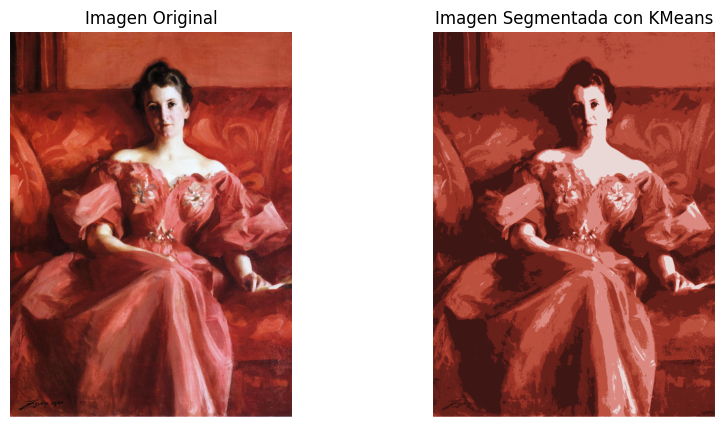

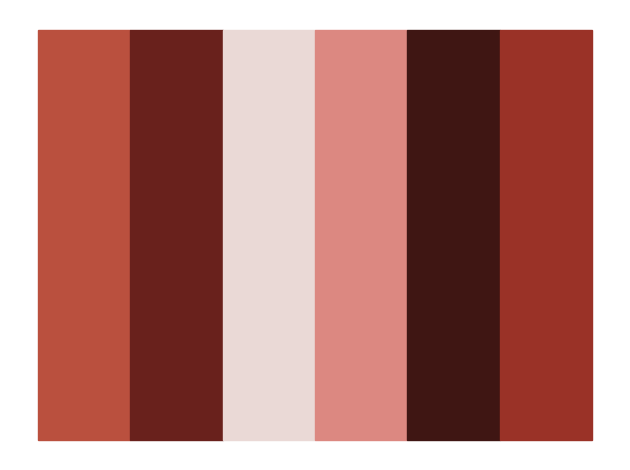

In [13]:
print_results(img_original[0])

Se procesan todas las imágenes secuencialmente

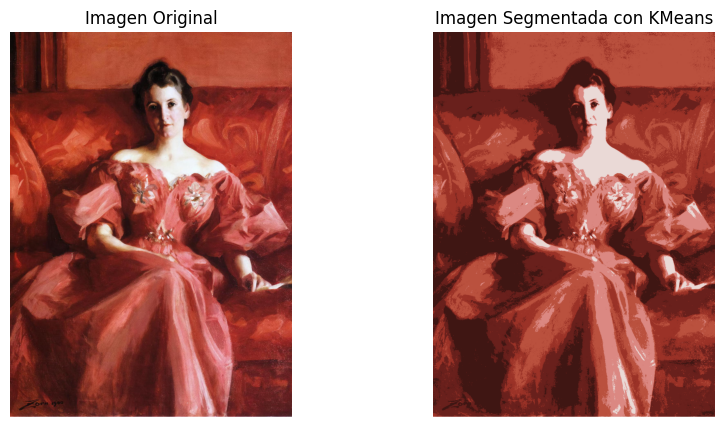

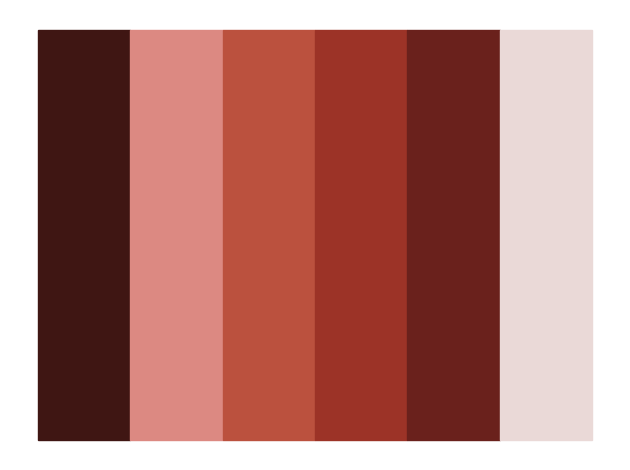

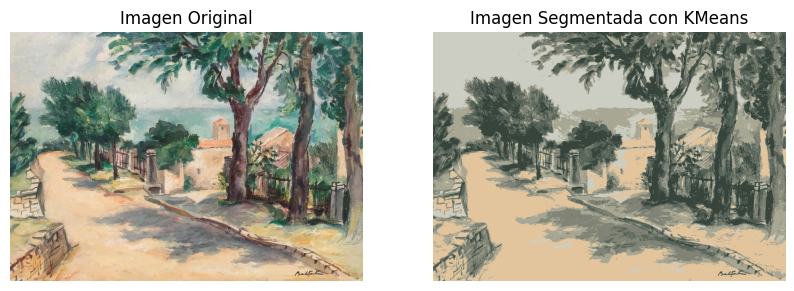

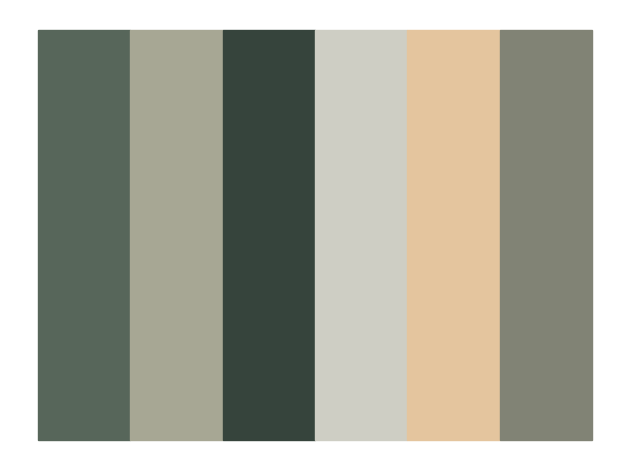

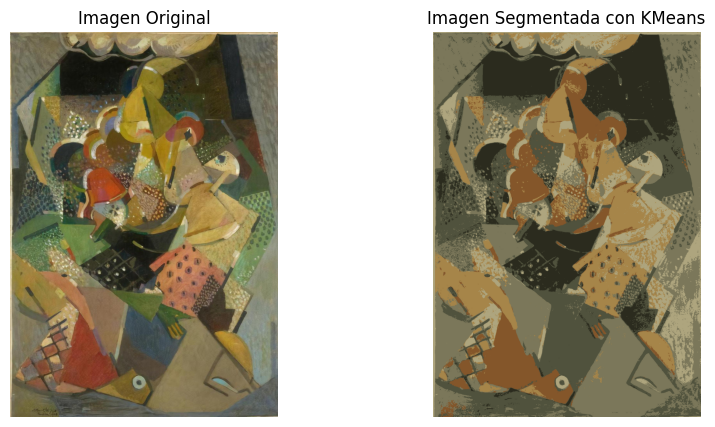

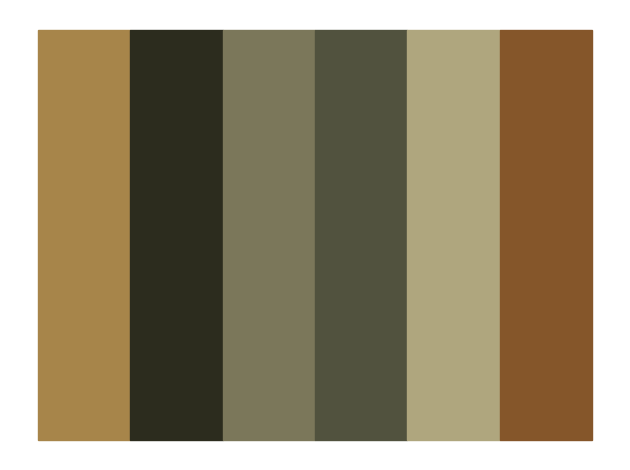

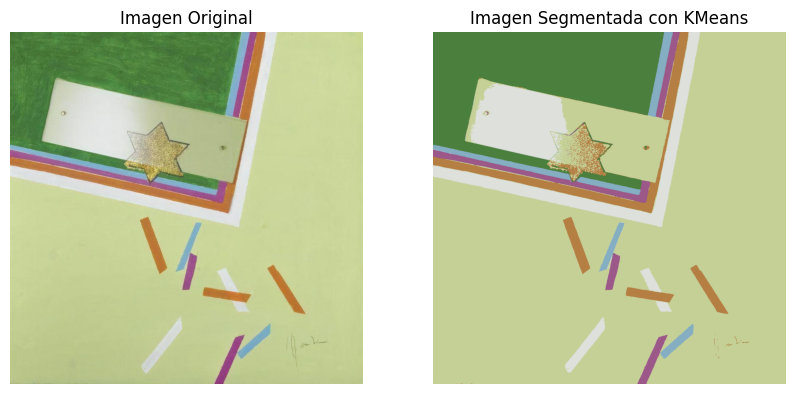

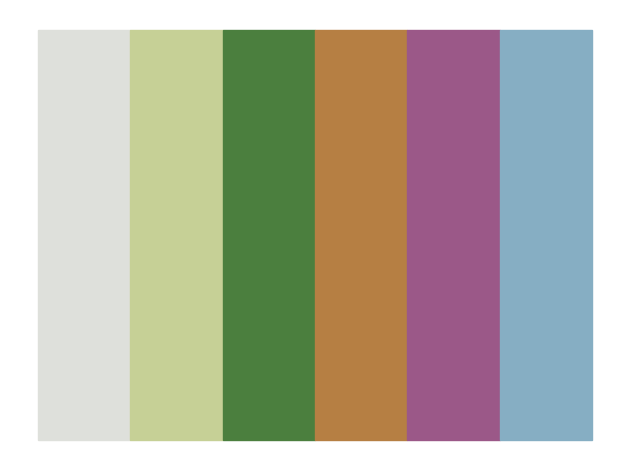

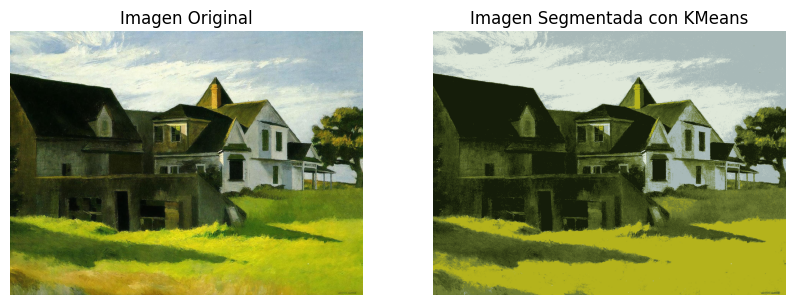

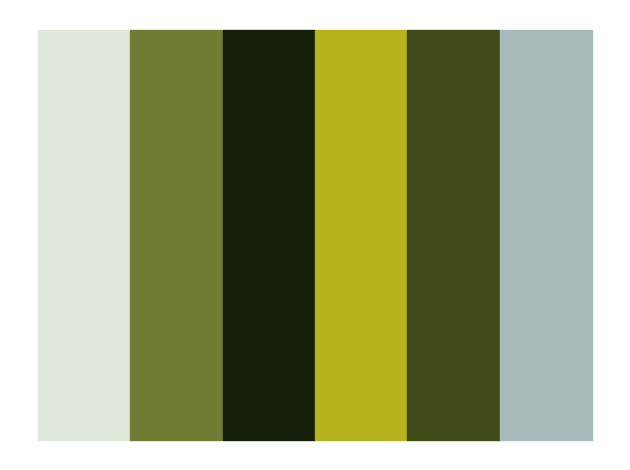

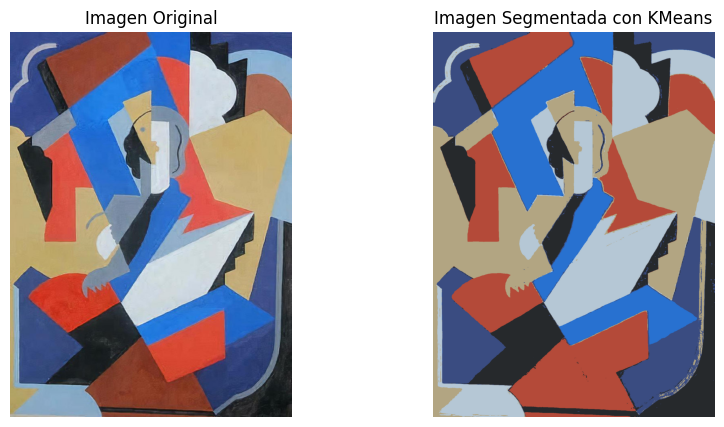

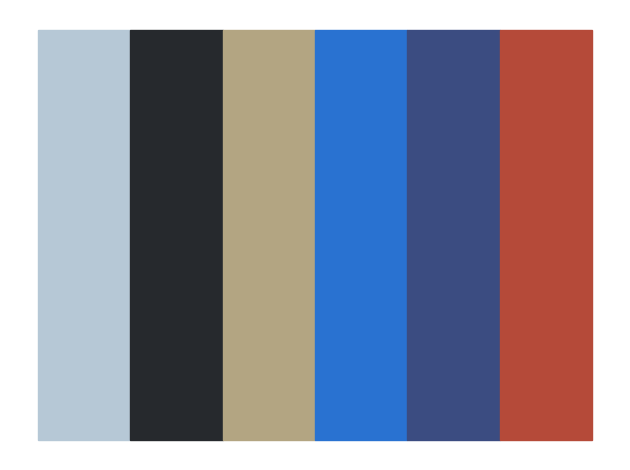

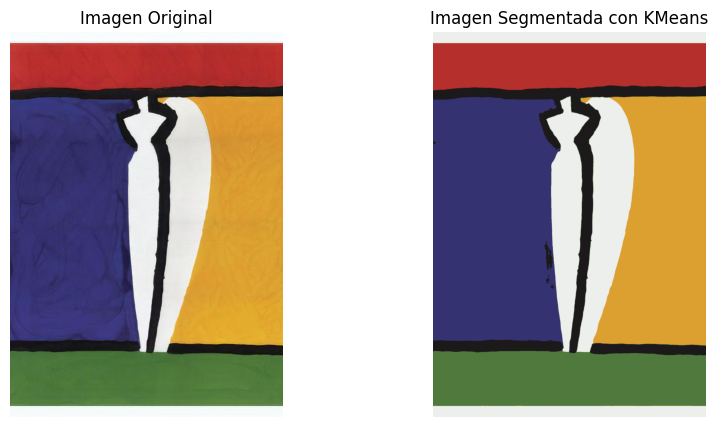

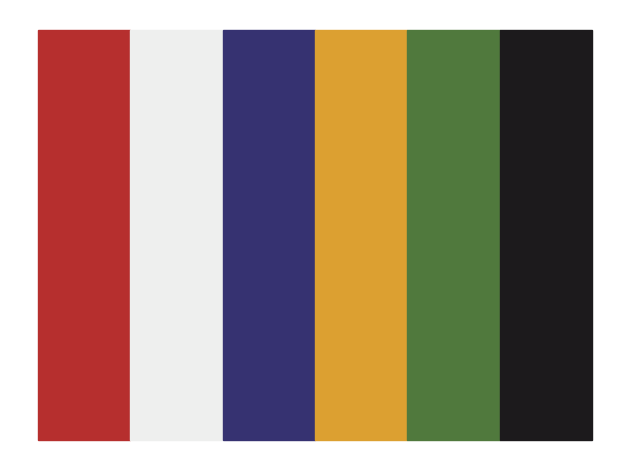

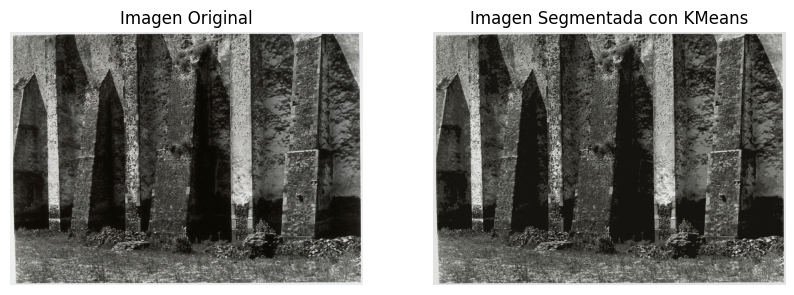

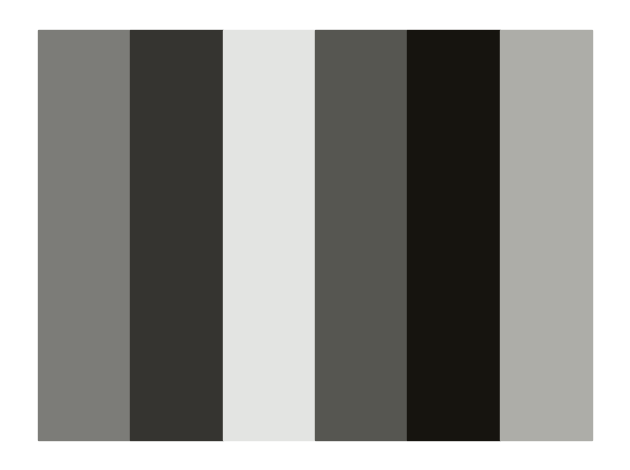

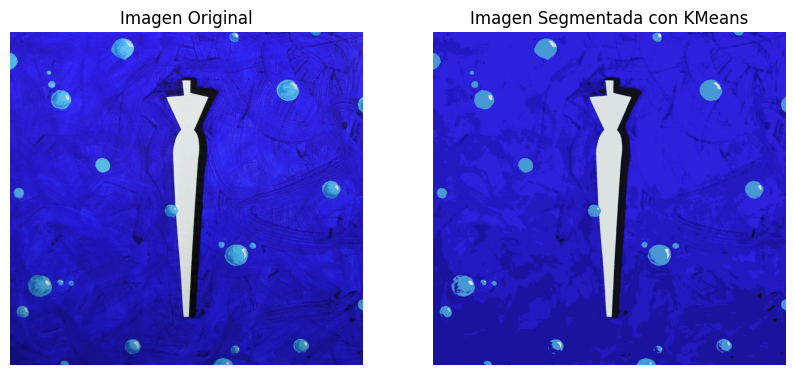

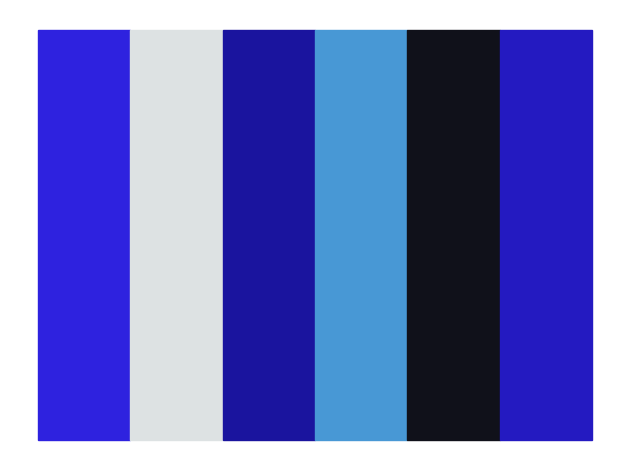

In [14]:
for i in range(len(img_list)):  
  kmeans.fit(img_list[i])
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_
  img_segmented = centroids[labels]*255
  img_segmented = img_segmented.reshape(img_original[i].shape)
  print_results(img_original[i])

## Pipeline

Especifico un máximo de iteraciones con el parámetro `max_iter`, defino `n_init=10` el cual es el valor por defecto para el número de veces en que el algoritmo K-Means se ejecuta con diferentes semillas de centroides

In [119]:
root_path = 'images'
img_files = os.listdir(root_path)
num_clusters = 6
img_list = load_images(root_path, img_files, flatten=True, normalize=True)
kmeans = KMeans(max_iter=300, n_init=10)
pipe = Pipeline(steps=[("Carga y Normalización", img_list), ("model", kmeans)])